# 网页爬取+多模态内容识别+RAG构建本地知识库+中文大语言模型

1. 网页爬取和解析，生成本地元数据 网站： [OrcaStudio使用指南](http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/README)

2. 分析元数据中的文本和图片，放入 vector store

3. 基于 vector store + qwen 模型的问答功能

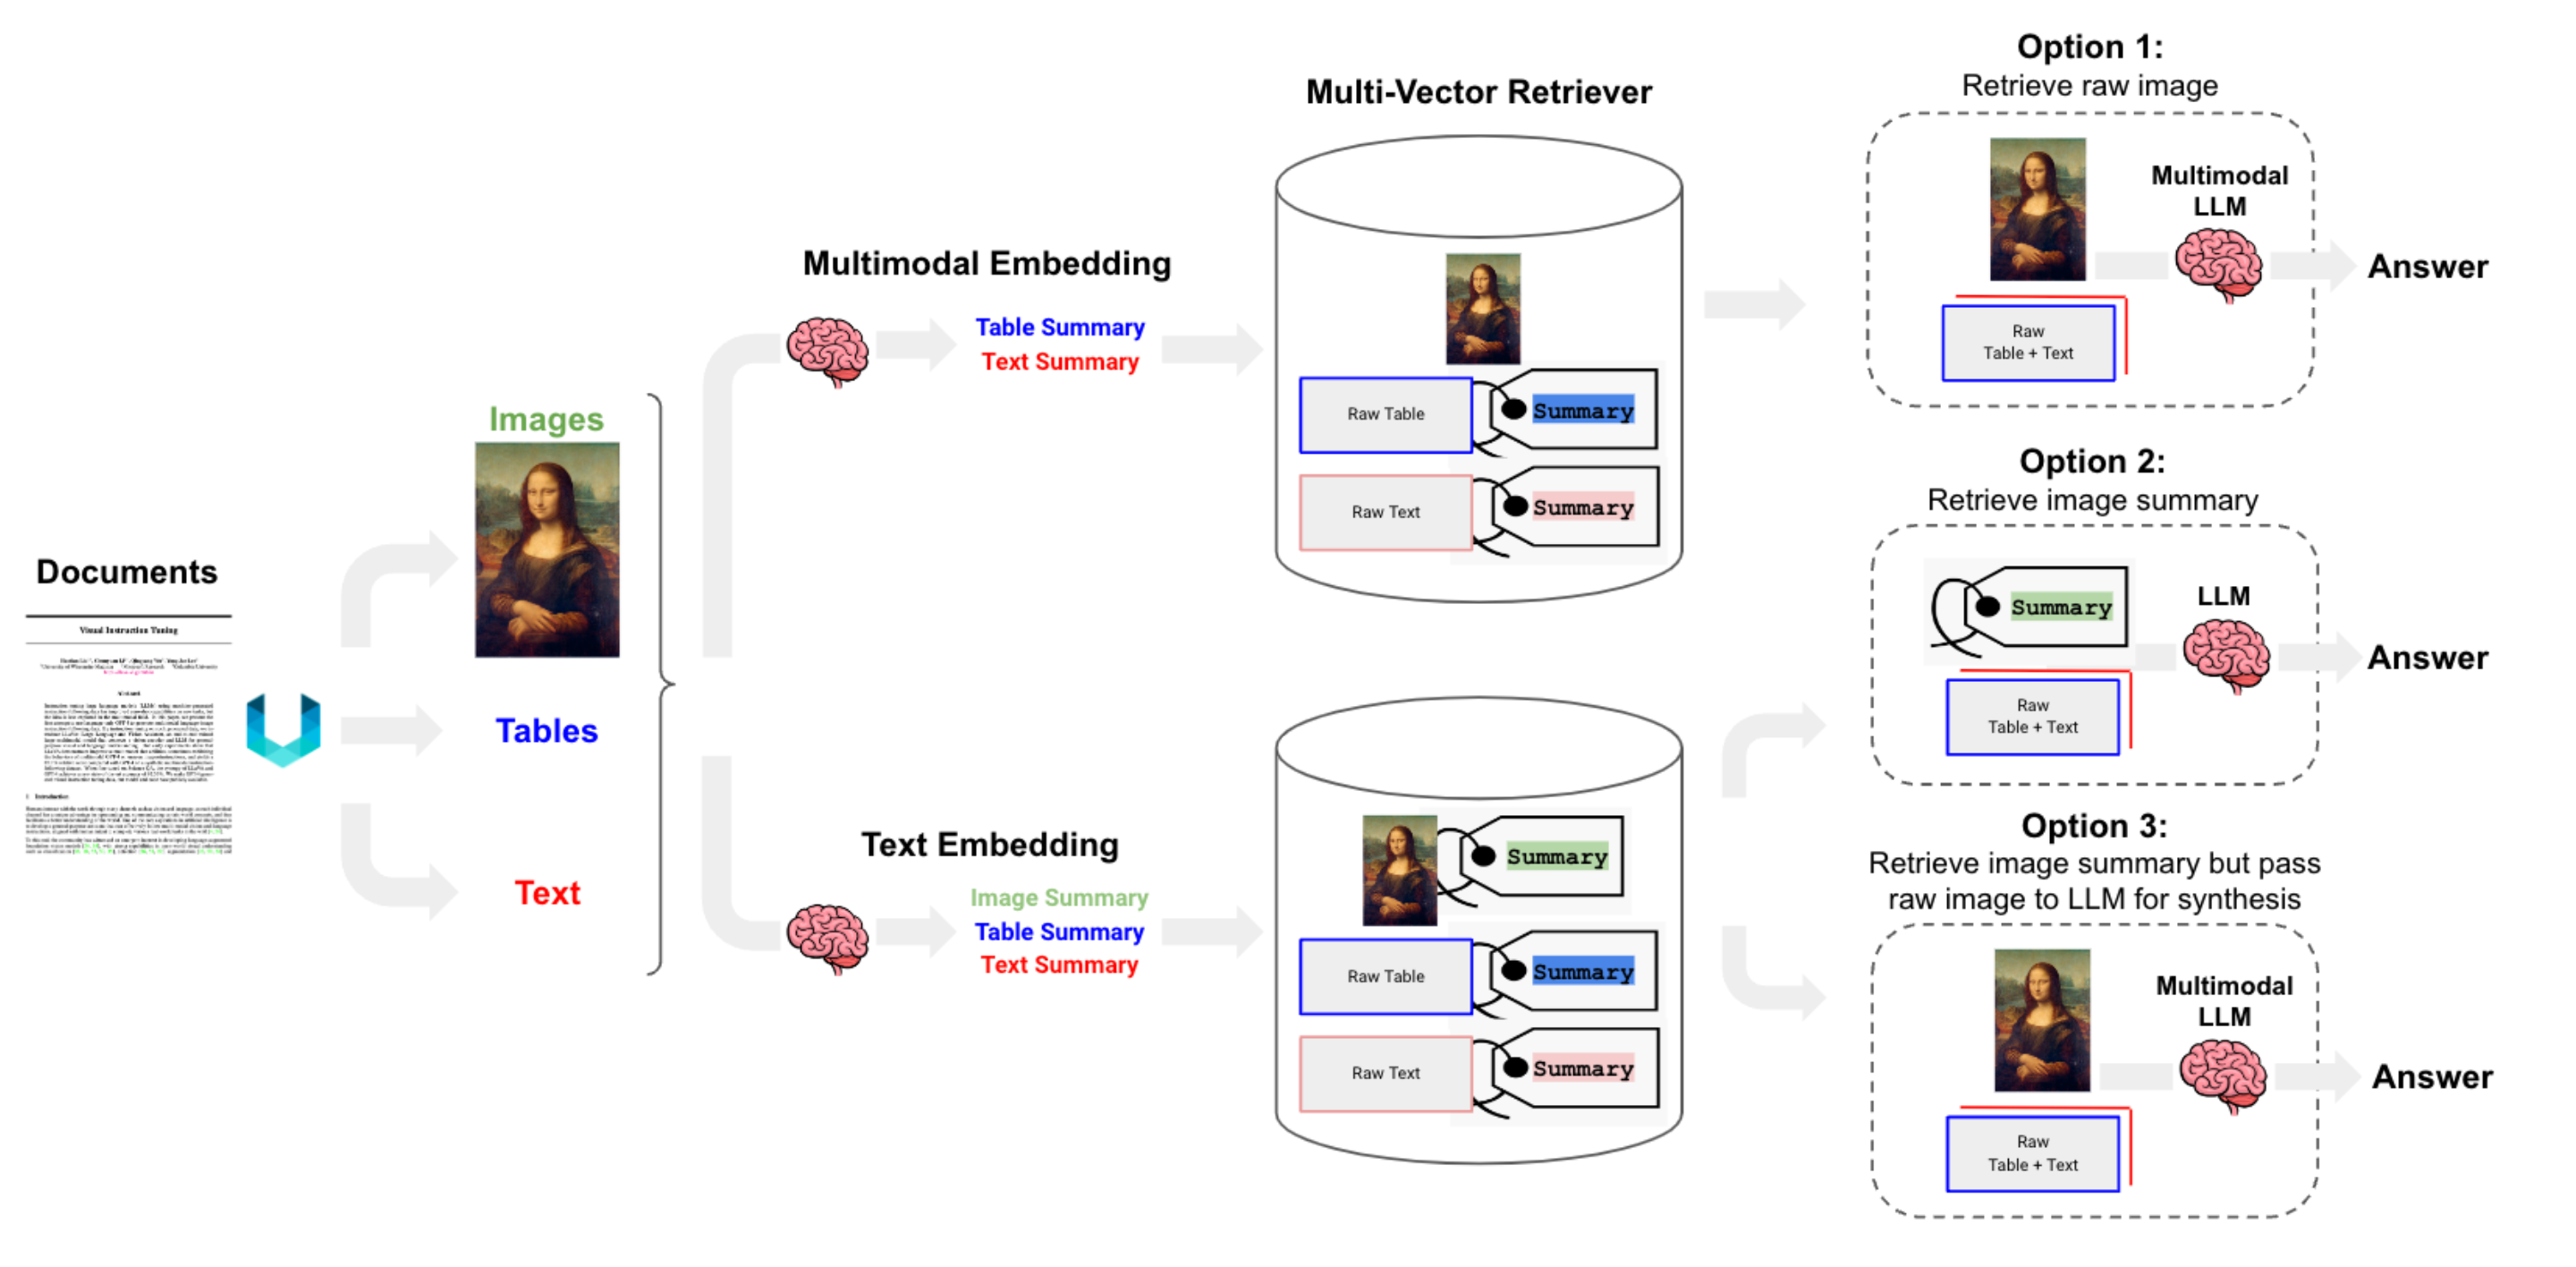



### 网页爬取和解析，生成本地元数据


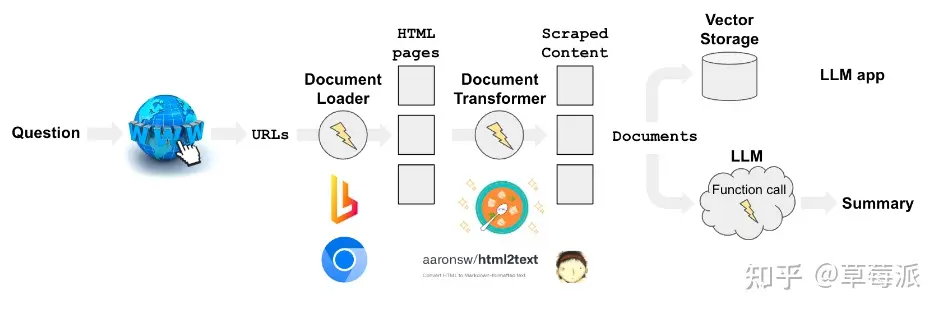

* Question->URLs: 通过URLs来search网页，可以是一个URL，也可以是多个URL

* Document Loader->HTML pages: 用langchain提供的文档加载器获取目标网页的html，如AsyncHtmlLoader, AsyncChromiumLoader等

* Document Transformer->Scraped Content: 用langchain提供的文档转换器工具解析HTML中的需要抓取的信息，如HTML2Tex或Beautiful Soup，形成格式化的文本

`暂时先采用保存到本地的方式保存网页数据`

### 解析HTML

* 从HTML内容中提取文本内容

* 采用unstructured工具进行网页数据读取

In [1]:
from typing import Any
from pydantic import BaseModel
from unstructured.partition.auto import partition

import glob
import os

# Get all .html files in the directory
path = "/home/huangwei1/Downloads/OrcaStudio_Htmls/"
file_paths = glob.glob(os.path.expanduser(os.path.join(path, "*.html")))

# Get elements
raw_html_elements_list = []
for file_path in file_paths:
    raw_html_elements_list.append(partition(
        filename=file_path,
        # Using pdf format to find embedded image blocks
        # extract_images_in_pdf=True,
        # Use layout model (YOLOX) to get bounding boxes (for tables) and find titles
        # Titles are any sub-section of the document
        infer_table_structure=True,
        # Post processing to aggregate text once we have the title

        chunking_strategy="by_title",
        # Chunking params to aggregate text blocks
        # Attempt to create a new chunk 3800 chars
        # Attempt to keep chunks > 2000 chars
        # Hard max on chunks
        max_characters=4000,
        new_after_n_chars=3800,
        combine_text_under_n_chars=2000,
        image_output_dir_path=path,
    ))

In [2]:
# Create a dictionary to store counts of each type
category_counts = {}

for raw_html_elements in raw_html_elements_list:
    for element in raw_html_elements:
        category = str(type(element))
        if category in category_counts:
            category_counts[category] += 1
        else:
            category_counts[category] = 1

# Unique_categories will have unique elements
# TableChunk if Table > max chars set above
unique_categories = set(category_counts.keys())
category_counts

{"<class 'unstructured.documents.elements.CompositeElement'>": 67}

In [3]:
class Element(BaseModel):
    type: str
    text: Any


# Categorize by type
categorized_elements = []

for raw_html_elements in raw_html_elements_list:
    for element in raw_html_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
            categorized_elements.append(Element(type="table", text=str(element)))
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
            categorized_elements.append(Element(type="text", text=str(element)))

# Tables
table_elements = [e for e in categorized_elements if e.type == "table"]
# print(table_elements)

# Text
text_elements = [e for e in categorized_elements if e.type == "text"]
# print(text_elements)
# print(len(text_elements))

# Image
image_elements = [e for e in categorized_elements if e.type == "image"]
# print(image_elements)

* 使用LLM提取文本摘要

In [4]:
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

In [5]:
# Prompt
prompt_text = """你是一个科技和计算机领域的助理，负责总结表格和文本。＼
基于科技和计算机领域知识，给出表格或文本的详细摘要。表格或文本块: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
qwen_model = ChatOllama(model="qwen:32b-chat-v1.5-q5_K_M")
summarize_chain = {"element": lambda x: x} | prompt | qwen_model | StrOutputParser()

In [ ]:
# Apply to text （注意：运行时间很长）
texts = [i.text for i in text_elements if i.text != ""]
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})


* 持久化原始文本和摘要

In [ ]:
print(len(text_summaries))
print(len(texts))

import json
import codecs

data = []

for i in range(0, len(texts)):
    d = {
        "summary" : text_summaries[i],
        "text" : texts[i]
    }
    data.append(d)

json_file = codecs.open("/home/huangwei1/Downloads/OrcaStudio_Htmls/texts_parsed.json", 'w', 'utf-8')
json_str = json.dumps(data, ensure_ascii=False)
json_file.write(json_str)


### 分析图片


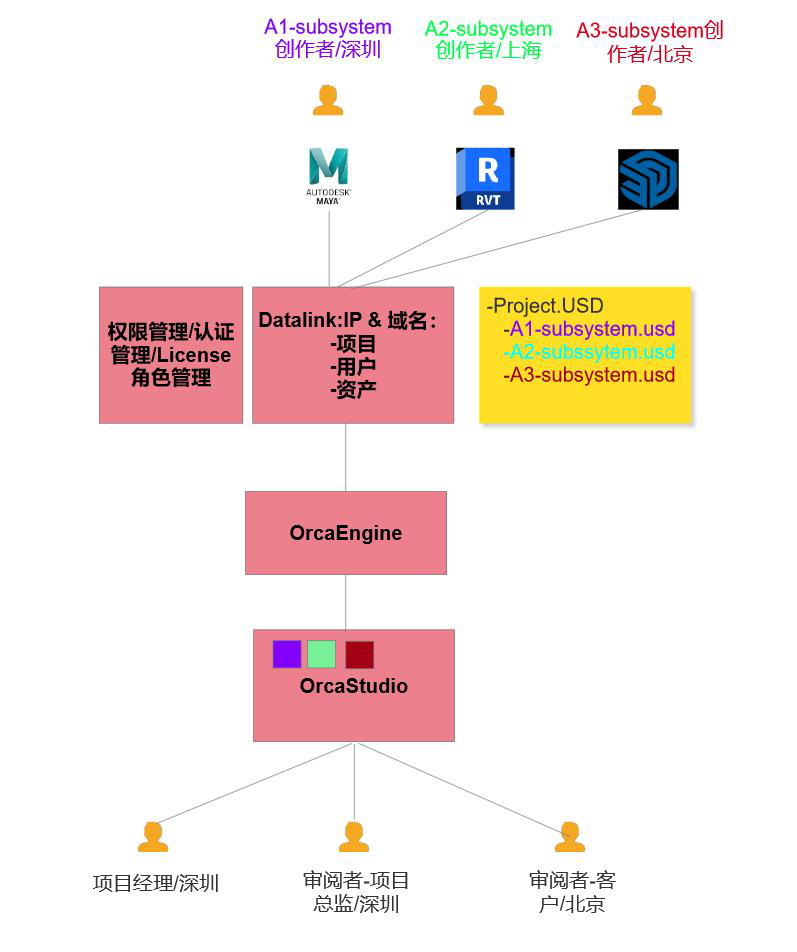

In [84]:
import base64
from io import BytesIO

from IPython.display import HTML, display
from PIL import Image


def convert_to_base64(pil_image):
    """
    Convert PIL images to Base64 encoded strings

    :param pil_image: PIL image
    :return: Re-sized Base64 string
    """

    buffered = BytesIO()
    pil_image.save(buffered, format="png")  # You can change the format if needed
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str


def plt_img_base64(img_base64):
    """
    Disply base64 encoded string as image

    :param img_base64:  Base64 string
    """
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


file_path = "/home/huangwei1/Downloads/OrcaStudio_Htmls/多人协同场景_files/LunarStudio_cowork_1.jpg"
pil_image = Image.open(file_path)

image_b64 = convert_to_base64(pil_image)
plt_img_base64(image_b64)

In [85]:
from langchain_community.chat_models import ChatOllama
from langchain_core.messages import HumanMessage

llm = ChatOllama(model="llava:34b-v1.6-q5_K_M")


def prompt_func(data):
    text = data["text"]
    image = data["image"]

    image_part = {
        "type": "image_url",
        "image_url": f"data:image/jpeg;base64,{image}",
    }

    content_parts = []

    text_part = {"type": "text", "text": text}

    content_parts.append(image_part)
    content_parts.append(text_part)

    return [HumanMessage(content=content_parts)]


from langchain_core.output_parsers import StrOutputParser

chain = prompt_func | llm | StrOutputParser()

query_chain = chain.invoke(
    {"text": "你是一个软件和计算机图形学领域的助理，基于软件和计算机图形学领域知识，详细描述图片的内容", "image": image_b64}
)

print(query_chain)


In [35]:
from langchain_community.llms import Ollama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

# Prompt
prompt_text = """详细描述这张图片的内容 {image} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
llava_model = Ollama(model="llava:34b-v1.6-q5_K_M")
llava_summarize_chain = {"image": lambda x: x} | prompt | llava_model | StrOutputParser()

In [45]:
# Apply to text （注意：运行时间很长）
# image_path = ["/home/huangwei1/Downloads/OrcaStudio_Htmls/3D功能概述_file/engine_landcanvas.png", 
#               "/home/huangwei1/Downloads/OrcaStudio_Htmls/3D功能概述_file/engine_pathtracer.png",
#               "/home/huangwei1/Downloads/OrcaStudio_Htmls/3D功能概述_file/engine_terrian.png",
#               "/home/huangwei1/Downloads/OrcaStudio_Htmls/3D功能概述_file/engine_pathtracer1.png",
#               "/home/huangwei1/Downloads/OrcaStudio_Htmls/3D功能概述_file/engine_pathtracer_indoor1.png"]
# image_summaries = llava_summarize_chain.batch(image_path, {"max_concurrency": 5})
print(llava_model.invoke(["详细描述这张图片的内容", "/home/huangwei1/Downloads/OrcaStudio_Htmls/3D功能概述_file/engine_pathtracer_indoor1.png"]))
print(llava_model.invoke("详细描述这张图片的内容，本地图片路径：/home/huangwei1/Downloads/OrcaStudio_Htmls/3D功能概述_file/engine_landcanvas.png"))

很抱歉，我无法提供您请求的图片的详细描述。因为我无法访问该图片。如果您可以提供该图片的描述或者更清晰的信息，我将尽力帮助您。<|im_end|>
非常抱歉，我无法访问或显示图像。作为AI模型，我没有直接访问文件的功能。如果您能提供更多信息或者将图片上传到某个公开网站，我将尽力为您描述图片内容。<|im_end|>


In [37]:
for sum in image_summaries:
    print(sum)

很抱歉，我无法浏览或提供您请求的图片。如果您可以提供图片内容或者将图片上传到共享平台上，我可以尝试回答您的问题。<|im_end|>
很抱歉，我无法看到您提到的图片。如果您可以提供图片的链接或上传图片到公共平台，我将尽力回答您的问题。<|im_end|>
抱歉，我无法查看或解释图片内容。请提供更多的上下文信息，以便我能更好地了解您的问题并为您提供帮助。<|im_end|>
抱歉，作为AI语言模型，我无法直接描述您指定的图片内容。由于您提供的图片文件路径不完整，因此我不能访问并查看该图片。如果您可以提供正确的图片文件路径或直接将图片上传到我这里，我将非常乐意帮助您详细描述其内容。<|im_end|>
很抱歉，我不能直接访问该图像。请提供有关图像的更多信息，例如描述或关键词，以便我可以帮助您更好地理解其内容。<|im_end|>


### 写入 vector storage

* Use [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) with summaries.

* 读取先前持久化的文本原文和摘要

* summaries 需要向量化，Embedding采用北京人工智能研究院的 bge 模型，存储在 Chroma DB 中

In [70]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
# from langchain_community.embeddings import GPT4AllEmbeddings
from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document

import json
import codecs


json_file_load = codecs.open("/home/huangwei1/Downloads/OrcaStudio_Htmls/texts_parsed.json", 'r', 'utf-8')
json_str_load = json_file_load.read()
data_load = json.loads(json_str_load)
print(len(data_load))

texts_load = []
text_summaries_load = []
for data in data_load:
    texts_load.append(data['text'])
    text_summaries_load.append(data['summary'])


# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    # collection_name="summaries", embedding_function=GPT4AllEmbeddings()
    collection_name="summaries", embedding_function=OllamaEmbeddings(model="znbang/bge:large-zh-v1.5-f16")
)

# The storage layer for the parent documents
store = InMemoryStore()  # <- Can we extend this to images
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

67


* Store the image summary in the `docstore`, which we return to the LLM for answer generation.

In [71]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts_load]
summary_texts = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries_load)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts_load)))


# # Add images
# img_ids = [str(uuid.uuid4()) for _ in cleaned_img_summary]
# summary_img = [
#     Document(page_content=s, metadata={id_key: img_ids[i]})
#     for i, s in enumerate(cleaned_img_summary)
# ]
# retriever.vectorstore.add_documents(summary_img)
# retriever.docstore.mset(
#     list(zip(img_ids, cleaned_img_summary))
# )  # Store the image summary as the raw document

In [78]:
retriever.get_relevant_documents("Orca Studio")[
    0
]

'OrcaStudio使用文档\n\nOrcaStudio产品概述公司介绍 行业理解 产品定位 使用场景 软件使用安装要求软件安装  DataLink安装软件界面使用流程项目使用\n\n使用流程 多人协同场景单机使用场景\n\nUSD使用介绍概述USD的协同作用为何使用USDUSD能做什么USD不能做什么皮克斯的USDUSD渲染配置可成像内容使用灯光使用材质使用图像文件格式定义渲染相机配置渲染设置USD协同示例Maya与OrcaStudio协同步骤\n\nOrcaEngine3D引擎概述资产处理路径追踪器PBR基础PBR理论基础贴图介绍PBR工作流UDIM贴图动态骨骼过场动画编辑器过场动画编辑器介绍过场动画编辑器使用步骤3D功能概述机器人仿真\n\nOrca Datalink产品概述 使用指南\n\nOrca Connector产品概述开发指南AEC场景  数字孪生  艺术创作  职业教育\n\nOrca AI产品概述\n\nOrca AssetsStore产品概述上传资产\n\nUSD能做什么\n\nUSD的表示效果\n\nUSD 将数据组织到 Prims（“primitive”的缩写）的分层命名空间中。 除了子 prim 之外，每个 prim\n还可以包含属性和关系，统称为属性。 属性具有可随时间变化的键入值； 关系是指向层次结构中其他对\n象的多目标“指针”，当引用导致名称空间发生更改时，USD 会自动重新映射目标。 prims 和 property 都\n可以有（非时变的）元数据。 Prims 及其内容被组织成称为层的文件抽象。\n\nUSD 建立在这种低级通用场景描述之上，提供了一组模式，为常见 3D 计算机图形概念建立标准编\n码和客户端 API，例如：\n\n几何学\nUsdGeom 模式定义了 OpenSubdiv 兼容的网格、变换、曲线、点、nurbs 面片和一些内在实体。\n它还定义： 任意原变量的概念作为可以在几何表面上插值的属性； 几何范围和聚合、计算的边界框； 修\n剪可见度； 以及一个名为目的的属性，它表示对于部署详细级别代理和指南有用的（不可动画的）条件\n可见性。\n\n阴影\nUsdShade 架构定义了原始着色器节点，这些节点可以连接到网络并打包到可重用材质中，在这些\n节点上可以创建属性的公共接口，该属性将驱动所包含的着色器网络

In [13]:
from langchain_core.runnables import RunnablePassthrough
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

qwen_model = ChatOllama(model="qwen:32b-chat-v1.5-q5_K_M")

# Prompt template
template = """你是一个科技和计算机领域的助理，仅根据以下上下文(可以包括文本和表格)，详细地回答问题:
{context}
问题: {question}
"""
prompt = ChatPromptTemplate.from_template(template)


# RAG pipeline
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | qwen_model
    | StrOutputParser()
)

In [14]:
print(chain.invoke(
    "一步一步地分析，阐述 Orca Studio 、Orca Connector 以及 Datalink 三者之间是什么关系"
))

KeyboardInterrupt: 